In [1]:
# Third party imports
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Reload library
from importlib import reload

# Local application imports
import smile.smile; reload(smile.smile)
from smile.smile import PopulationList, Methodology, RegressionResultList
import smile.example_populations; reload(smile.example_populations)
import smile.helper; reload(smile.helper);

In [3]:
# Settings
seed = 3 # chosen by fair dice roll. guaranteed to be random. https://xkcd.com/221/
np.random.seed(seed)
np.set_printoptions(edgeitems=30, linewidth=100000)

# Population generation

In [4]:
pops_noerror, pops_mulerror, pops_adderror = smile.example_populations.get_useful_poplists(100)
    
pops_noerror.generate()
pops_mulerror.generate()
pops_adderror.generate()

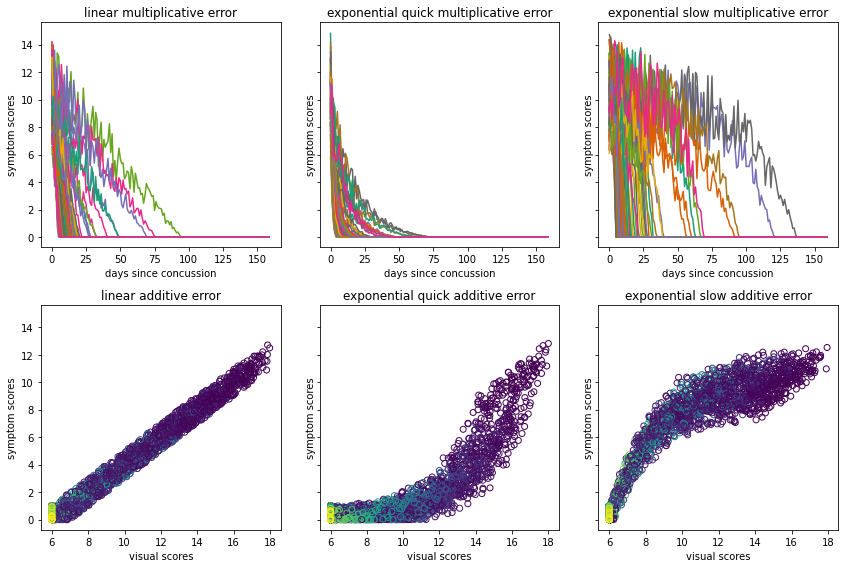

In [5]:
ncols = len(pops_noerror)
nrows = len([pops_mulerror, pops_adderror])

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=plt.figaspect(nrows/ncols)*2, sharey=True)
npersons=None
ndays=None

pops_mulerror.plot(axes[0, :], x='day', y='symptom', viztype='lines', vizcolor='person', npersons=npersons, ndays=ndays)
pops_adderror.plot(axes[1, :], x='visual', y='symptom', viztype='points', vizcolor='day', npersons=npersons, ndays=ndays)
    
plt.tight_layout()
plt.show()

# Study

## Comparing traditional studies

In [6]:
pops = pops_mulerror

In [7]:
methodologies = [Methodology('trad short', [8, 15, 29]), Methodology('trad long', [8, 29, 90])]

meth_pops = []
for methodology in methodologies:
    meth_pops.append(methodology.sample(pops))

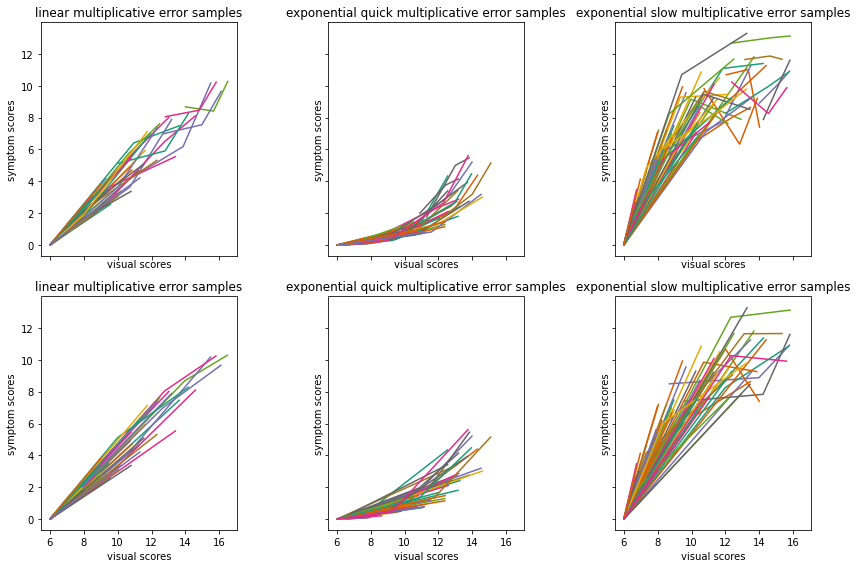

In [8]:
ncols = len(meth_pops[0])
nrows = len(meth_pops)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=plt.figaspect(nrows/ncols)*2, sharex=True, sharey=True)
npersons=None
ndays=None

for row in range(nrows):
    meth_pops[row].plot(axes[row, :], x='visual', y='symptom', viztype='lines', vizcolor='person', npersons=npersons, ndays=ndays)
    
plt.tight_layout()
plt.show()

## Comparing traditional to smile studies

In [9]:
pops = pops_adderror

In [10]:
methodologies2 = [Methodology('trad short', [8, 15, 29, 90]), Methodology('smile', [8, 0.7, 0.4, 0.1])]

meth_pops2 = []
for methodology in methodologies2:
    meth_pops2.append(methodology.sample(pops))

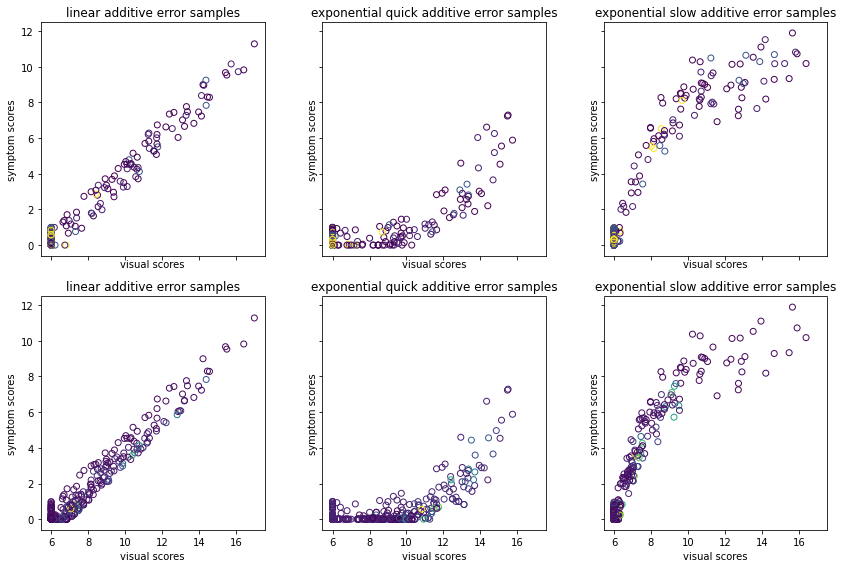

In [11]:
ncols = len(meth_pops2[0])
nrows = len(meth_pops2)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=plt.figaspect(nrows/ncols)*2, sharex=True, sharey=True)
npersons=None
ndays=None

for row in range(nrows):
    meth_pops2[row].plot(axes[row, :], x='visual', y='symptom', viztype='points', vizcolor='day', npersons=npersons, ndays=ndays)
    
plt.tight_layout()
plt.show()

## Regression test

In [12]:
print("Stastmodels.regression.linear_model may give a RuntimeWarning: invalid value encountered in double_scalars."
      +"This happens due to a np.NaN when calculating the rsquared value")
poplist_reglists = []
for poplist in meth_pops2:
    reglists = poplist.regress_persons(x='visual', y='symptom')
    poplist_reglists.append(reglists)

Stastmodels.regression.linear_model may give a RuntimeWarning: invalid value encountered in double_scalars.This happens due to a np.NaN when calculating the rsquared value


C:\tools\Anaconda3\envs\smile\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


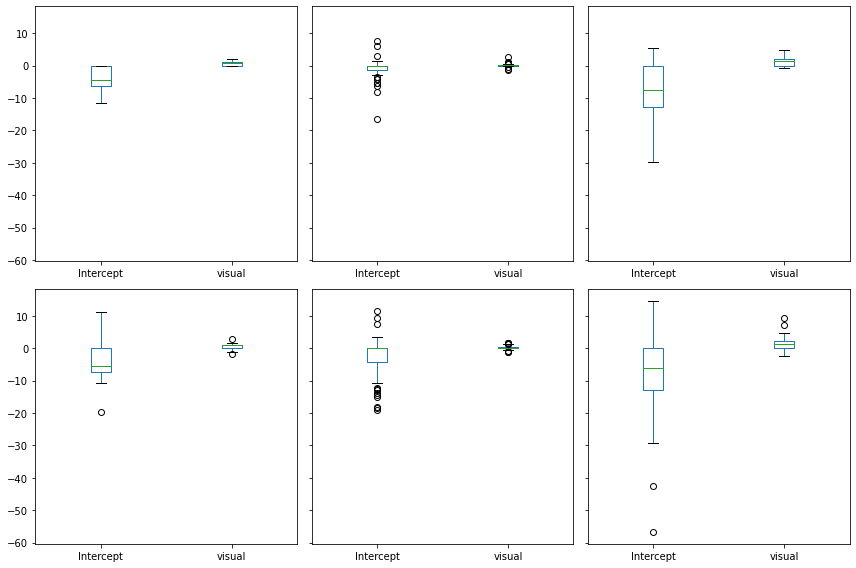

In [13]:
ncols = len(meth_pops2[0])
nrows = len(meth_pops2)

fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=plt.figaspect(nrows/ncols)*2, sharey=True)

for row in range(nrows):
    for col in range(ncols):
        poplist_reglists[row][col].plot_box(axes[row, col])
        
plt.tight_layout()
plt.show()

In [14]:
import pandas as pd
with pd.option_context('display.float_format', lambda s: '{:8.2f}'.format(s)):
    for row in range(nrows):
        text_blocks = []
        for col in range(ncols):
            df = poplist_reglists[row][col].params_dataframe
            dfoutliers = pd.concat([df.min(), df.max()], axis=1)
            dfoutliers.columns = ["min", "max"]
            text_blocks.append(str(dfoutliers))
        print(smile.helper.collocate_text(text_blocks))
        print()

               min      max		               min      max		               min      max
Intercept   -11.43     0.01		Intercept   -16.35     7.76		Intercept   -29.86     5.38
visual        0.00     1.91		visual       -1.22     2.77		visual       -0.83     4.98

               min      max		               min      max		               min      max
Intercept   -19.68    11.12		Intercept   -19.12    11.63		Intercept   -56.82    14.72
visual       -1.75     2.88		visual       -1.11     1.70		visual       -2.43     9.47



In [15]:
import pandas as pd
with pd.option_context('display.float_format', lambda s: '{:8.2f}'.format(s)):
    for row in range(nrows):
        text_blocks = []
        for col in range(ncols):
            df = poplist_reglists[row][col].params_dataframe
            dfoutliers = pd.concat([df.idxmin(), df.idxmax()], axis=1)
            dfoutliers.columns = ["idxmin", "idxmax"]
            text_blocks.append(str(dfoutliers))
        print(smile.helper.collocate_text(text_blocks))
        print()

           idxmin  idxmax		           idxmin  idxmax		           idxmin  idxmax
Intercept      29      66		Intercept      88       8		Intercept      39      13
visual         63      29		visual          8      88		visual         13      39

           idxmin  idxmax		           idxmin  idxmax		           idxmin  idxmax
Intercept      46      66		Intercept      31      22		Intercept      50      88
visual         66      46		visual         22      98		visual         88      50



Summary of worst outlier population+methodology:



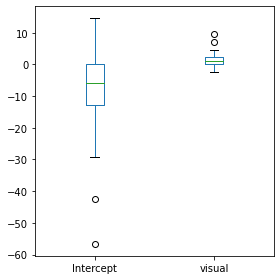


                 min        max			           idxmin  idxmax
Intercept -56.820521  14.724427			Intercept      50      88
visual     -2.427357   9.470087			visual         88      50


In [16]:
print("Summary of worst outlier population+methodology:")
print()

(worst_meth_idx, worst_pop_idx) = (1, 2) #set manually, looking at worse outlier from previous cells
pop_w_outliers = pops[worst_meth_idx]
pop_sampled_w_outliers = meth_pops2[worst_meth_idx][worst_pop_idx] 
regs_w_outliers = poplist_reglists[worst_meth_idx][worst_pop_idx]

fig, ax = plt.subplots(figsize=plt.figaspect(1/1)*1, sharey=True)
regs_w_outliers.plot_box(ax)
plt.tight_layout()
plt.show()

print()

df = regs_w_outliers.params_dataframe
dfoutliers = pd.concat([df.min(), df.max()], axis=1)
dfoutliersidx = pd.concat([df.idxmin(), df.idxmax()], axis=1)
dfoutliers.columns = ["min", "max"]
dfoutliersidx.columns = ["idxmin", "idxmax"]

smile.helper.print_collocated([dfoutliers, dfoutliersidx], separatorlen=3)

In-depth summary of worst outlier population+methodology:

             person  day    visual  symptom_noerror  symptom				             person  day    visual  symptom_noerror   symptom
observation                                                 				observation                                                  
0                 0  8.0  6.086294         0.301751  0.81721				0                 0  8.0  6.000000        -0.000000  0.160283
1                 0  9.0  6.000000        -0.000000  0.00000				1                 0  7.0  6.066032         0.296325  0.000000
2                 0  9.0  6.000000        -0.000000  0.00000				2                 0  7.0  6.066032         0.296325  0.000000
3                 0  9.0  6.000000        -0.000000  0.00000				3                 0  7.0  6.066032         0.296325  0.000000


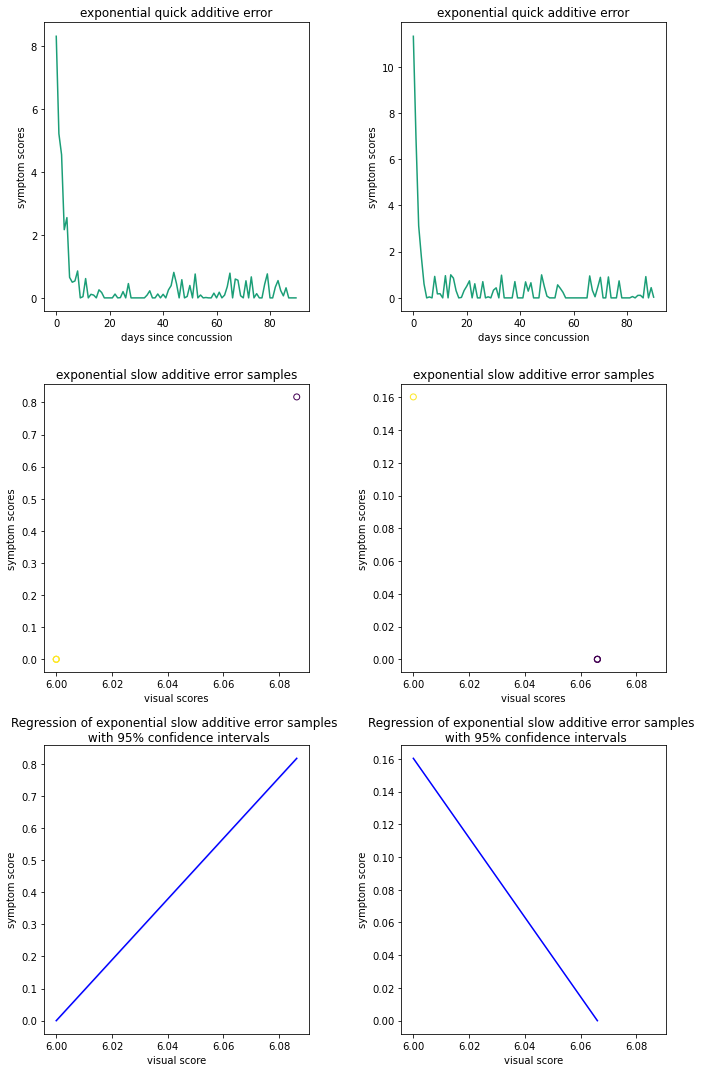

In [18]:
print("In-depth summary of worst outlier population+methodology:")
print()

indices = list(df.idxmin()) #could also use df.idxmax: both seem to give the same indices, but reversed

outliers = PopulationList([pop_w_outliers.get_person_as_population(idx) for idx in indices])
outliers_sampled = PopulationList([pop_sampled_w_outliers.get_person_as_population(idx) for idx in indices])
outliers_regressed = RegressionResultList([regs_w_outliers[idx] for idx in indices])

ncols=len(outliers)
nrows=3 # also equal to len([outliers, outliers_sampled, outliers_regressed])
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=plt.figaspect(nrows/ncols)*2.5, squeeze=False, sharex='row')

outliers.plot(axes[0, :], x='day', y='symptom', viztype='lines', vizcolor='person', ndays=91)
outliers_sampled.plot(axes[1, :], x='visual', y='symptom', viztype='points', vizcolor='day')
smile.helper.print_collocated([str(outlier_sampled.to_dataframe()) for outlier_sampled in outliers_sampled], separatorlen=4)
#TODO add to smile.smile.RegressionResultList
for col in range(ncols):
    outliers_regressed[col].plot_line(axes[2, col], alpha=0.05)
plt.tight_layout()
plt.show()

Problem: regression fails spectacularly when multiple visual scores get the same symptom score
Solution: filter better